# Boosting auf dem Titanic-Datensatz: AdaBoost, Gradient Boosting, XGBoost

In diesem Notebook vergleichen wir drei Boosting-Algorithmen auf dem Titanic-Datensatz aus `seaborn`:

- `AdaBoostClassifier` (scikit-learn)
- `GradientBoostingClassifier` (scikit-learn)
- `XGBClassifier` (xgboost)

Zielvariable: `survived` (0 = nicht überlebt, 1 = überlebt)

Wir gehen dabei so vor:
1. Daten laden und kurz inspizieren  
2. Features auswählen und vorverarbeiten (Numerik + Kategorien)  
3. Einheitliche Pipeline aufbauen  
4. Drei Modelle trainieren  
5. Performance vergleichen


In [25]:
# Imports

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

# Achtung: xgboost muss installiert sein: pip install xgboost
from xgboost import XGBClassifier


## 1. Titanic-Datensatz laden und inspizieren
Wir verwenden den Titanic-Datensatz direkt aus `seaborn`.  
Zuerst schauen wir uns ein paar Zeilen und die Grundstruktur an.


In [2]:
# Titanic-Daten laden
titanic = sns.load_dataset("titanic")

# Erste Zeilen anzeigen
titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
# Kurzer Überblick: Spalten, Datentypen, Missing Values
titanic.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


## 2. Zielvariable und Features definieren

Zielvariable: `survived`  
Wir wählen eine Mischung aus numerischen und kategorialen Features, die sich gut für ein Klassifikationsmodell eignen.

**Numerische Features (Beispiele):**
- `age`
- `fare`
- `sibsp` (siblings/spouses aboard)
- `parch` (parents/children aboard)

**Kategoriale Features (Beispiele):**
- `pclass`
- `sex`
- `embarked`
- `alone`
- `who`
- `deck` (hat viele Missing Values – wird per Imputer behandelt)

Du kannst diese Auswahl später beliebig anpassen/erweitern.


In [4]:
# Zielvariable
y = titanic["survived"]

# Feature-Auswahl
numeric_features = ["age", "fare", "sibsp", "parch"]
categorical_features = ["pclass", "sex", "embarked", "alone", "who", "deck"]

X = titanic[numeric_features + categorical_features]

# Kurzer Check
X.head()


,age,fare,sibsp,parch,pclass,sex,embarked,alone,who,deck
0,22.0,7.2500,1,0,3,male,S,False,man,NaN
1,38.0,71.2833,1,0,1,female,C,False,woman,C
2,26.0,7.9250,0,0,3,female,S,True,woman,NaN
3,35.0,53.1000,1,0,1,female,S,False,woman,C
4,35.0,8.0500,0,0,3,male,S,True,man,NaN


## 3. Train-Test-Split

Wir teilen die Daten in Trainings- und Testdaten auf, damit wir die Modelle fair vergleichen können.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((712, 10), (179, 10))

## 4. Vorverarbeitungspipeline

Wir bauen eine `ColumnTransformer`-Pipeline:

- Numerische Features:
  - `SimpleImputer` (z. B. Median)
  - `StandardScaler`

- Kategoriale Features:
  - `SimpleImputer` (häufigster Wert)
  - `OneHotEncoder`

Diese Vorverarbeitung wird für alle drei Modelle identisch verwendet.


In [6]:
# Pipeline für numerische Spalten
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]
)

# Pipeline für kategoriale Spalten
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

# Gemeinsamer ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## 5. Hilfsfunktion zur Evaluation

Wir schreiben eine kleine Funktion, die:

- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC

berechnet und optional die Confusion Matrix anzeigt.


In [7]:
def evaluate_model(name, model, X_test, y_test, plot_cm=True):
    y_pred = model.predict(X_test)
    
    # Für ROC-AUC: Wahrscheinlichkeiten, falls verfügbar
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_proba)
    else:
        roc_auc = np.nan
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1-Score : {f1:.3f}")
    print(f"ROC-AUC  : {roc_auc:.3f}")
    print()
    
    if plot_cm:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(cm, display_labels=["nicht überlebt", "überlebt"])
        disp.plot(values_format="d")
        plt.title(f"Confusion Matrix – {name}")
        plt.show()


## 6. AdaBoost-Modell (scikit-learn)

Wir verwenden `AdaBoostClassifier` aus scikit-learn, mit einem einfachen DecisionTree-Stump (Tiefe 1) als Base-Estimator.


=== AdaBoost ===
Accuracy : 0.816
Precision: 0.773
Recall   : 0.739
F1-Score : 0.756
ROC-AUC  : 0.858



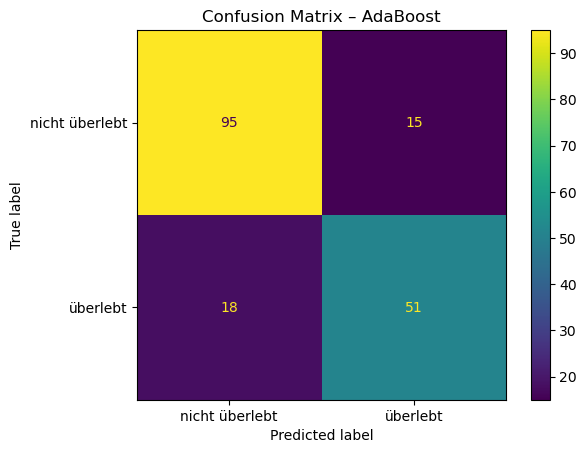

In [8]:
# AdaBoost-Pipeline
ada_base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", AdaBoostClassifier(
            estimator=ada_base_estimator,
            n_estimators=200,
            learning_rate=0.5,
            random_state=42
        ))
    ]
)

ada_clf.fit(X_train, y_train)
evaluate_model("AdaBoost", ada_clf, X_test, y_test)


## 7. Gradient Boosting (scikit-learn)

Wir verwenden `GradientBoostingClassifier` aus scikit-learn.  
Das Modell arbeitet intern mit Regressionsbäumen und optimiert schrittweise eine Loss-Funktion (hier Log-Loss).


=== Gradient Boosting ===
Accuracy : 0.810
Precision: 0.807
Recall   : 0.667
F1-Score : 0.730
ROC-AUC  : 0.851



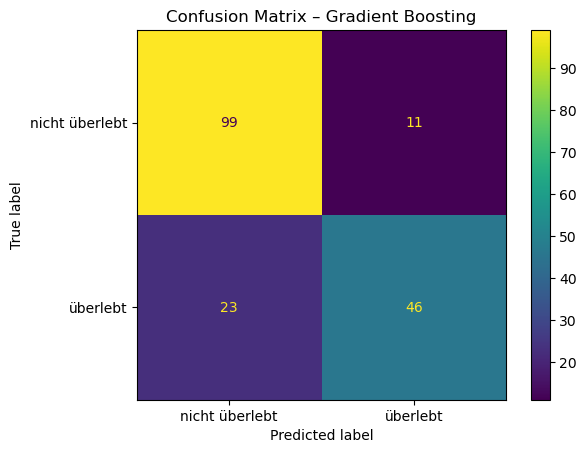

In [9]:
gb_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            random_state=42
        ))
    ]
)

gb_clf.fit(X_train, y_train)
evaluate_model("Gradient Boosting", gb_clf, X_test, y_test)


## 8. XGBoost (xgboost.XGBClassifier)

Jetzt verwenden wir `XGBClassifier` aus der XGBoost-Bibliothek.  
XGBoost ist eine optimierte, regulierte Variante von Gradient Boosting mit 2. Ordnung (Newton-Schritten) und zusätzlicher Regularisierung.

Hinweis: Für reproduzierbare Experimente setzen wir `random_state` und begrenzen z. B. `n_estimators` und `max_depth`.


=== XGBoost ===
Accuracy : 0.827
Precision: 0.817
Recall   : 0.710
F1-Score : 0.760
ROC-AUC  : 0.844



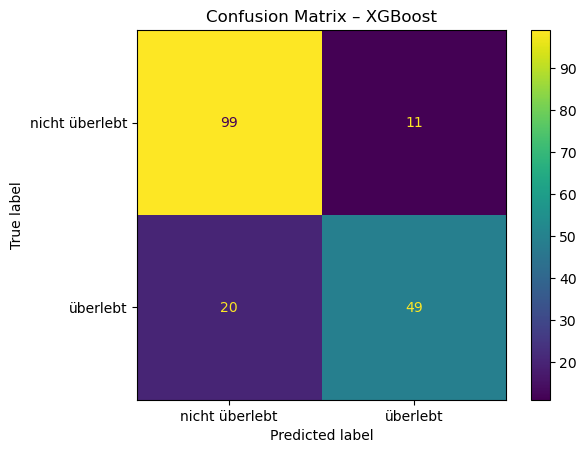

In [10]:
xgb_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

xgb_clf.fit(X_train, y_train)
evaluate_model("XGBoost", xgb_clf, X_test, y_test)


## 9. Vergleich der drei Modelle

An dieser Stelle haben wir:

- AdaBoost (Gewichte der Datenpunkte werden angepasst)
- Gradient Boosting (arbeitet mit negativen Gradienten / Pseudo-Residuen)
- XGBoost (Gradient Boosting mit 2. Ordnung und zusätzlicher Regularisierung)

Mögliche Beobachtungspunkte für die Studierenden:

- Welche Modelle erreichen die höchste Accuracy / ROC-AUC?
- Wie unterscheiden sich die Confusion-Matrizen? (z. B. Recall für „überlebt“)
- Wie stark reagieren die Modelle auf Hyperparameter wie `n_estimators`, `learning_rate`, `max_depth`?

Optional lassen sich noch:

- Feature Importances auslesen und vergleichen
- Lernkurven (Train/Test-Score vs. n_estimators) plotten
- Hyperparameter-Tuning per GridSearch oder RandomizedSearch ergänzen


# 10. Hyperparameter-Tuning für Boosting-Modelle

Nachdem wir die drei Boosting-Verfahren (AdaBoost, Gradient Boosting und XGBoost) einmal „out of the box“
ausprobiert haben, wollen wir nun testen, wie sensibel die Modelle auf ihre Hyperparameter reagieren.

Wir verwenden:
- `GridSearchCV` für kleine, didaktisch gut interpretierbare Gitter
- denselben Preprocessing-Block wie vorher
- Accuracy als Metrik (optional könnte man auch Recall oder ROC-AUC verwenden)

Wir halten die Grids bewusst klein, damit die Studierenden die Auswirkungen klar nachvollziehen können.


Beste Parameter (AdaBoost):
{'model__estimator__max_depth': 2, 'model__learning_rate': 1.0, 'model__n_estimators': 100}

Bestes CV-Ergebnis: 0.8273121244952228
=== AdaBoost (getuned) ===
Accuracy : 0.788
Precision: 0.738
Recall   : 0.696
F1-Score : 0.716
ROC-AUC  : 0.841



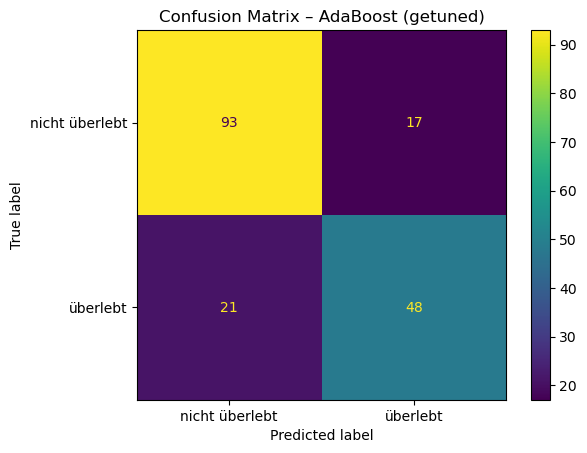

In [13]:
ada_grid = {
    "model__n_estimators": [50, 100, 200],
    "model__learning_rate": [0.1, 0.3, 1.0],
    "model__estimator__max_depth": [1, 2]
}

ada_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", AdaBoostClassifier(
            estimator=DecisionTreeClassifier(random_state=42),
            random_state=42
        ))
    ]
)

ada_search = GridSearchCV(
    ada_pipeline,
    ada_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

ada_search.fit(X_train, y_train)

print("Beste Parameter (AdaBoost):")
print(ada_search.best_params_)
print("\nBestes CV-Ergebnis:", ada_search.best_score_)

evaluate_model("AdaBoost (getuned)", ada_search.best_estimator_, X_test, y_test)


Beste Parameter (Gradient Boosting):
{'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__n_estimators': 100}

Bestes CV-Ergebnis: 0.824544469614892
=== Gradient Boosting (getuned) ===
Accuracy : 0.821
Precision: 0.814
Recall   : 0.696
F1-Score : 0.750
ROC-AUC  : 0.844



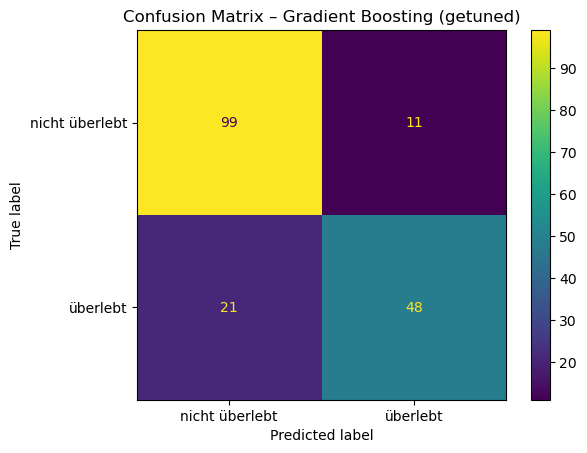

In [14]:
gb_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__max_depth": [2, 3, 4]
}

gb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", GradientBoostingClassifier(random_state=42))
    ]
)

gb_search = GridSearchCV(
    gb_pipeline,
    gb_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

gb_search.fit(X_train, y_train)

print("Beste Parameter (Gradient Boosting):")
print(gb_search.best_params_)
print("\nBestes CV-Ergebnis:", gb_search.best_score_)

evaluate_model("Gradient Boosting (getuned)", gb_search.best_estimator_, X_test, y_test)


Beste Parameter (XGBoost):
{'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 2, 'model__n_estimators': 200, 'model__subsample': 1.0}

Bestes CV-Ergebnis: 0.8343839259332217
=== XGBoost (getuned) ===
Accuracy : 0.810
Precision: 0.807
Recall   : 0.667
F1-Score : 0.730
ROC-AUC  : 0.833



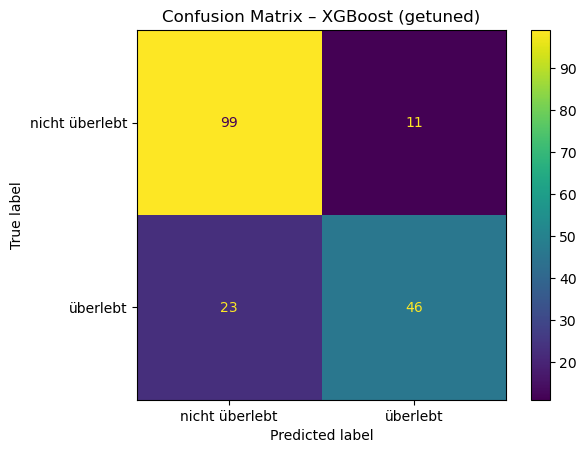

In [15]:
xgb_grid = {
    "model__n_estimators": [100, 200],
    "model__learning_rate": [0.03, 0.1],
    "model__max_depth": [2, 3, 4],
    "model__subsample": [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0]
}

xgb_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1
        ))
    ]
)

xgb_search = GridSearchCV(
    xgb_pipeline,
    xgb_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

xgb_search.fit(X_train, y_train)

print("Beste Parameter (XGBoost):")
print(xgb_search.best_params_)
print("\nBestes CV-Ergebnis:", xgb_search.best_score_)

evaluate_model("XGBoost (getuned)", xgb_search.best_estimator_, X_test, y_test)


# 12. Vergleich aller drei Boosting-Modelle – Vorher vs. Nachher (mit Tuning)

Um die Wirkung des Hyperparameter-Tunings besser zu verstehen, vergleichen wir
die Modelle vor und nach dem Tuning anhand der wichtigsten Metriken:

- Accuracy  
- Precision  
- Recall  
- F1-Score  
- ROC-AUC

Wir erzeugen zunächst eine Tabelle, anschließend optional eine Visualisierung.


In [16]:
# Hilfsfunktion zum Sammeln aller Scores
def get_scores(model, X_test, y_test):
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, proba)
    else:
        auc = np.nan

    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1": f1_score(y_test, y_pred, zero_division=0),
        "ROC-AUC": auc
    }


In [17]:
scores_before = pd.DataFrame({
    "AdaBoost (default)": get_scores(ada_clf, X_test, y_test),
    "Gradient Boosting (default)": get_scores(gb_clf, X_test, y_test),
    "XGBoost (default)": get_scores(xgb_clf, X_test, y_test),
}).T

scores_before


,Accuracy,Precision,Recall,F1,ROC-AUC
AdaBoost (default),0.815642,0.772727,0.739130,0.755556,0.857576
Gradient Boosting (default),0.810056,0.807018,0.666667,0.730159,0.851449
XGBoost (default),0.826816,0.816667,0.710145,0.759690,0.843808


In [18]:
scores_after = pd.DataFrame({
    "AdaBoost (tuned)": get_scores(ada_search.best_estimator_, X_test, y_test),
    "Gradient Boosting (tuned)": get_scores(gb_search.best_estimator_, X_test, y_test),
    "XGBoost (tuned)": get_scores(xgb_search.best_estimator_, X_test, y_test),
}).T

scores_after


,Accuracy,Precision,Recall,F1,ROC-AUC
AdaBoost (tuned),0.787709,0.738462,0.695652,0.716418,0.841173
Gradient Boosting (tuned),0.821229,0.813559,0.695652,0.750000,0.844203
XGBoost (tuned),0.810056,0.807018,0.666667,0.730159,0.833202


# 13. Besseres (?) Tuning am Beispiel XGBoost

Unser erstes Grid war absichtlich klein und einfach, deshalb war es
nicht überraschend, dass die Ergebnisse teils schlechter wurden als die Defaults.

Jetzt machen wir ein etwas ernsthafteres Tuning für **XGBoost**:

- wir verwenden `RandomizedSearchCV` statt kleinem Grid,
- wir durchsuchen einen größeren, sinnvoll strukturierten Hyperparameterraum,
- wir optimieren auf **ROC-AUC** (besser als reine Accuracy bei unbalancierten Klassen),
- wir begrenzen die Anzahl der Versuche (`n_iter`), damit es praktikabel bleibt.

Schauen wir, ob das was bringt...n.

In [30]:
# Basis-Pipeline für XGBoost
xgb_base = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=42,
        ))
    ]
)

# Hyperparameter-Raum (sinnvoll, aber nicht zu groß)
param_dist_xgb = {
    "model__n_estimators": randint(200, 800),        # Anzahl Bäume
    "model__learning_rate": uniform(0.01, 0.19),     # 0.01–0.2
    "model__max_depth": randint(2, 6),               # Tiefe 2–5
    "model__subsample": uniform(0.7, 0.3),           # 0.7–1.0
    "model__colsample_bytree": uniform(0.7, 0.3),    # 0.7–1.0
    "model__min_child_weight": randint(1, 11),       # 1–10
    "model__reg_lambda": uniform(0.0, 5.0),          # L2-Regularisierung
}

xgb_random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_dist_xgb,
    n_iter=50,              # Anzahl zufälliger Kombinationen
    scoring="roc_auc",      # Fokus auf Trennschärfe
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

xgb_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'model__colsample_bytree': <scipy.stats....0019CA9180590>, 'model__learning_rate': <scipy.stats....0019CA91AAE10>, 'model__max_depth': <scipy.stats....0019CA921D690>, 'model__min_child_weight': <scipy.stats....0019CA91F89D0>, ...}"
,n_iter,50
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [31]:
print("Beste Parameter (XGBoost, RandomizedSearch):")
print(xgb_random_search.best_params_)
print("\nBestes CV-Ergebnis (ROC-AUC):", xgb_random_search.best_score_)


Beste Parameter (XGBoost, RandomizedSearch):
{'model__colsample_bytree': np.float64(0.9821375753058743), 'model__learning_rate': np.float64(0.1912464296304916), 'model__max_depth': 2, 'model__min_child_weight': 6, 'model__n_estimators': 298, 'model__reg_lambda': np.float64(3.7385938694870697), 'model__subsample': np.float64(0.985921554107186)}

Bestes CV-Ergebnis (ROC-AUC): 0.8865472910927457


=== XGBoost (gut getuned) ===
Accuracy : 0.816
Precision: 0.833
Recall   : 0.652
F1-Score : 0.732
ROC-AUC  : 0.838



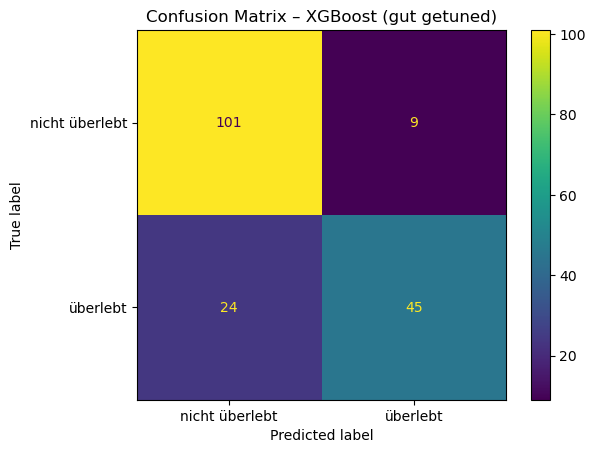

In [32]:
# Evaluation auf dem Test-Set
evaluate_model("XGBoost (gut getuned)", xgb_random_search.best_estimator_, X_test, y_test)


In [33]:
xgb_default_scores = get_scores(xgb_clf, X_test, y_test)
xgb_tuned_scores = get_scores(xgb_random_search.best_estimator_, X_test, y_test)

pd.DataFrame(
    [xgb_default_scores, xgb_tuned_scores],
    index=["XGBoost (default)", "XGBoost (gut getuned)"]
)

,Accuracy,Precision,Recall,F1,ROC-AUC
XGBoost (default),0.826816,0.816667,0.710145,0.759690,0.843808
XGBoost (gut getuned),0.815642,0.833333,0.652174,0.731707,0.837813


### Der Titanic-Datensatz ist klein und relativ einfach
Mit wenigen gut informierten Variablen (Geschlecht, Alter, Klasse) erreichen viele Modelle schon eine „Sättigung“ im Bereich 80–83% Accuracy.  
Darüber hinaus gibt es wenig echte Struktur, die komplexere Modelle nutzen könnten.

### Mehr Modellkomplexität hilft nicht immer
Höhere Tiefe, mehr Bäume oder geringere Lernraten verbessern ein Modell nur,
wenn es **ungenutzte Struktur** in den Daten gibt.

Beim Titanic-Datensatz ist die relevante Struktur bereits sehr gut durch:
- wenige Haupteffekte (sex, pclass, age),
- und einfache Interaktionen

erklärbar.  
Mehr Komplexität führt hier eher zu Overfitting oder „unerheblichen“ Veränderungen.